In [2]:
import os
import sys
import json
import torch
import numpy as np
import argparse
import transformers
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, field_key, random_seed, total_num):
        self.data = data
        self.field_key = field_key
        self.ids = list(range(len(data)))
        if random_seed >= 0:
            # shuffle the ids
            rng = np.random.default_rng(random_seed)
            rng.shuffle(self.ids)
            print(f"Shuffled IDs with seed {random_seed}")
        else:
            print("Not shuffling IDs")
        # select the first total_num ids
        self.ids = self.ids[:total_num]
            
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        _id = self.ids[idx]
        item = self.data[_id]

        if isinstance(self.field_key, str):
            text = item[self.field_key]
        elif isinstance(self.field_key, list):
            text = '\n'.join((item[key].strip() for key in self.field_key))
        return _id, text
    

In [ ]:
def observe(
        model: transformers.PreTrainedModel, 
        tokenizer: transformers.PreTrainedTokenizer, 
        dataloader: torch.utils.data.DataLoader, 
        max_length: int, 
    ):
    failure_cnts = []
    lm_head = model.lm_head
    underlying_model = model.model
    chunk_size = 10 # map the hiddenstates to logits in chunks

    # Disable gradient computation for inference
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            data_ids, data_texts = batch
            # Tokenize the batch
            inputs = tokenizer(data_texts, return_tensors="pt", truncation=True, max_length=max_length, padding=True)
            inputs = {k: v.to(next(iter(model.parameters())).device.type) for k, v in inputs.items()}
            
            # Forward pass
            hidden_states = underlying_model(**inputs).last_hidden_state

            input_ids = inputs['input_ids'].to(hidden_states.device)

            # Vectorized Processing Starts Here
            # Shift input_ids to get next_token_ids
            next_token_ids = input_ids[:, 1:].contiguous()  # Shape: (batch_size, seq_length -1)
            
            # Create a mask for tokens that are not special tokens
            special_ids = torch.tensor(tokenizer.all_special_ids, device=input_ids.device)
            mask = ~torch.isin(next_token_ids, special_ids)
            
            # Get indices of valid tokens
            valid_positions = mask.nonzero(as_tuple=False)  # Shape: (num_valid, 2)
            
            if valid_positions.numel() > 0:
                # Extract batch indices and sequence indices
                batch_indices = valid_positions[:,0]
                seq_indices = valid_positions[:,1]
                
                # Extract the true next token IDs
                true_token_ids = next_token_ids[batch_indices, seq_indices]  # Shape: (num_valid,)

                for i in range(1000, seq_indices.size(0), chunk_size): # start from 1000 to avoid the beginning of the sequence
                    chunk_batch_indices = batch_indices[i:i+chunk_size]
                    chunk_seq_indices = seq_indices[i:i+chunk_size]
                    # hidden_states: B, L, D
                    chunk_hidden_states = hidden_states[chunk_batch_indices, chunk_seq_indices, :]  # Shape: (num_valid, hidden_size)
                    chunk_logits = lm_head(chunk_hidden_states)  # Shape: (num_valid, vocab_size)
                    chunk_true_token_logits = chunk_logits[torch.arange(chunk_logits.size(0), device=chunk_logits.device), true_token_ids[i:i+chunk_size].to(chunk_logits.device)]  # Shape: (num_valid,)
                    chunk_failure_cnt = (chunk_logits > chunk_true_token_logits.unsqueeze(1)).sum(dim=1)
                    failure_cnts.extend(chunk_failure_cnt.cpu().numpy().tolist())

    return failure_cnts

In [8]:
device = torch.device('cuda:0')

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B", torch_dtype="auto").to(device)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

data = load_dataset("wikimedia/wikipedia", "20231101.en", split="train")
field_key = ["title", "text"]
max_length = 5000

Using the latest cached version of the dataset since wikimedia/wikipedia couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration '20231101.en' at /home/zjt/.cache/huggingface/datasets/wikimedia___wikipedia/20231101.en/0.0.0/b04c8d1ceb2f5cd4588862100d08de323dccfbaa (last modified on Tue Jan 28 17:50:33 2025).


Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

In [9]:
batch_size = 1
total_num = 1000
dataset = TextDataset(data, field_key, random_seed=42, total_num=total_num)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

failure_cnts = observe(
    model = model,
    tokenizer = tokenizer,
    dataloader = dataloader,
    max_length = max_length,
)

Shuffled IDs with seed 42


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


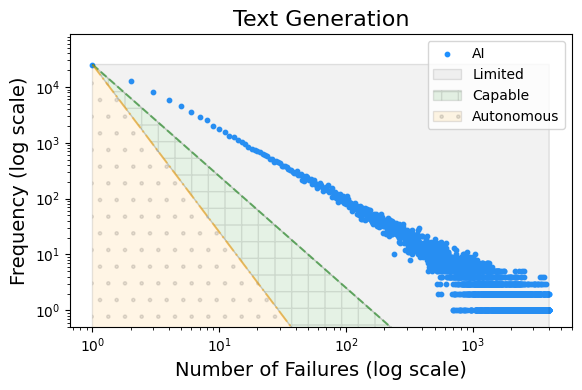

In [10]:
import matplotlib.pyplot as plt
import numpy as np

frequency = np.zeros(max(failure_cnts) + 1)
for cnt in failure_cnts:
    if cnt > 0 and cnt < len(frequency):
        frequency[cnt] += 1

plt.figure(figsize=(6, 4))

x = np.array(range(1, 4000))
# Plot histogram
plt.scatter(x, frequency[x], color="dodgerblue", s=10, label="AI")

y1 = (x.astype(np.float32))**-2 * frequency[1]
y2 = (x.astype(np.float32))**-3 * frequency[1]

# 绘制两条分界线, # label=r'$y \propto x^{-2}$',# label=r'$y \propto x^{-3}$',
plt.plot(x, y1,  color='green', linestyle='--', alpha=0.5) 
plt.plot(x, y2,  color='orange', linestyle='-.', alpha=0.5) 

# 填充不同区域
plt.fill_between(x, frequency[1], y1, color='gray', alpha=0.1, label="Limited", edgecolor="black")
plt.fill_between(x, y1, y2, color='green', alpha=0.1, hatch='+', label="Capable", edgecolor="black")
plt.fill_between(x, y2,0, color='orange', alpha=0.1, hatch='.', label="Autonomous", edgecolor="black")

# Set x-axis to log scale
plt.xscale('log')
# Set y-axis to log scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of Failures (log scale)', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.title(f'Text Generation', fontsize=16)

plt.tight_layout()

plt.legend(loc='upper right')

# set ylim lower bound to min(frequency)
plt.ylim(bottom=min(frequency[frequency > 0] / 2))

plt.show()
